
=== Training: LogisticRegression ===

=== Training: RandomForest ===

=== Training: GradientBoosting ===

Validation metrics (80/20 split) @ threshold 0.5:
             Model  Accuracy  Precision   Recall       F1  ROC_AUC   PR_AUC
      RandomForest  0.822066   0.949008 0.221952 0.359764 0.812678 0.620671
  GradientBoosting  0.821619   0.937732 0.222836 0.360100 0.763333 0.577016
LogisticRegression  0.821320   0.989540 0.208922 0.345004 0.734517 0.542272

Best model (by PR_AUC): RandomForest


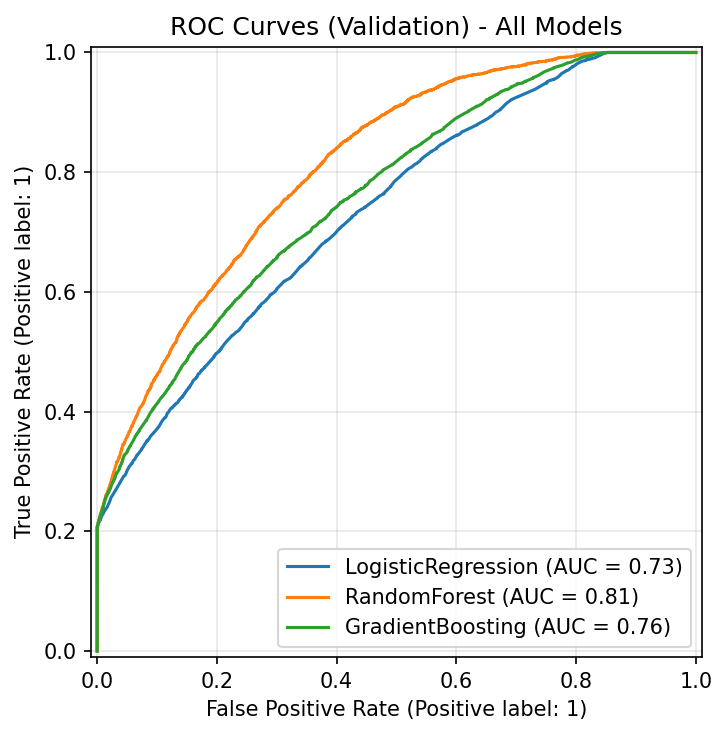

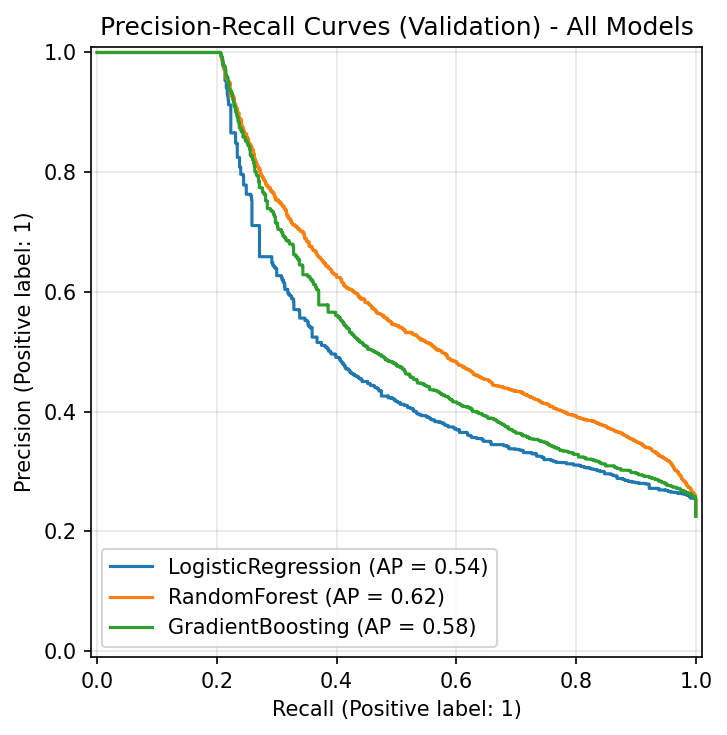


F2-optimal thresholds (validation):
- LogisticRegression: threshold = 0.12, F2 = 0.634
- RandomForest: threshold = 0.16, F2 = 0.687
- GradientBoosting: threshold = 0.14, F2 = 0.643


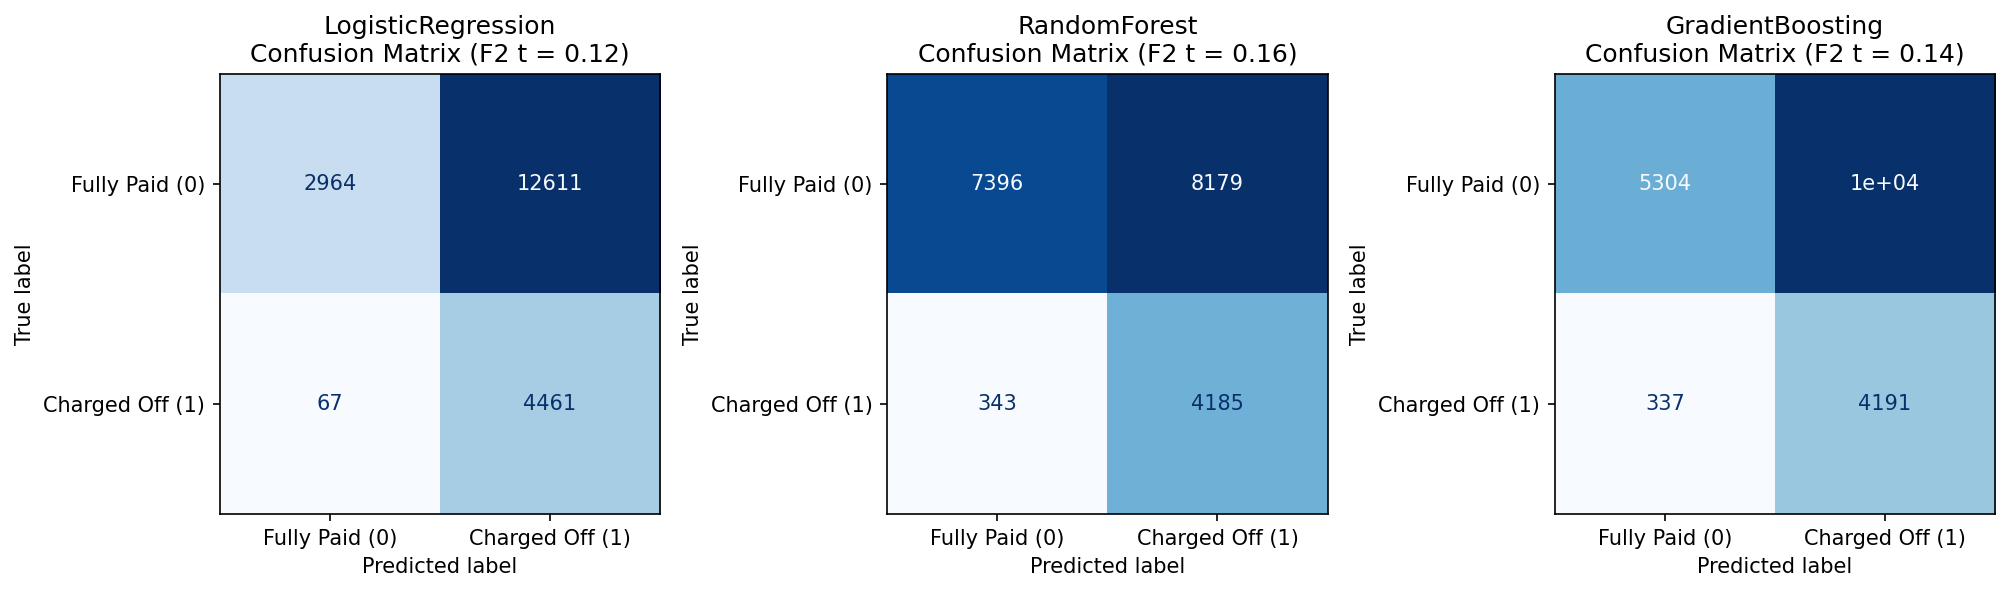


Using final model = RandomForest with F2 threshold = 0.16

Saved test predictions to 'test_set_predictions.csv'


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150



train = pd.read_csv("Training Data.csv")
test = pd.read_csv("Test data.csv")

TARGET = "Loan Status"
ID_COLS = [c for c in ["Loan ID", "Customer ID"] if c in train.columns]

# Map target: 1 = Charged Off, 0 = Fully Paid , now y is a target variable with loan status 1 or 0 set for all training data
y = (
    train[TARGET]
    .astype(str)
    .str.lower()
    .str.replace("_", " ")
    .str.strip()
    .str.contains("charged off")
    .astype(int)
)

X = train.drop(columns=[TARGET] + ID_COLS, errors="ignore")
X_test = test.drop(columns=ID_COLS, errors="ignore")


# Train / validation split (80/20 stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



# Preprocessing: impute + encode + scale

cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


# Defining models (class_weight for imbalance where possible)

base_models = {
    "LogisticRegression": LogisticRegression(
        max_iter=500, class_weight="balanced"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ),
    "GradientBoosting": GradientBoostingClassifier(
        random_state=42
    )
}

def make_calibrated_pipeline(estimator):
    # Calibrating probabilities
    calibrated = CalibratedClassifierCV(estimator, cv=3, method="isotonic")
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", calibrated)
    ])



# Training models

results = []
fitted_pipes = {}
val_probas = {}

for name, est in base_models.items():
    print(f"\n=== Training: {name} ===")
    pipe = make_calibrated_pipeline(est)
    pipe.fit(X_train, y_train)
    fitted_pipes[name] = pipe

    # Probabilities on validation set
    proba_val = pipe.predict_proba(X_val)[:, 1]
    val_probas[name] = proba_val

    # Default 0.5 predictions
    pred_val_05 = (proba_val >= 0.5).astype(int)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_val, pred_val_05),
        "Precision": precision_score(y_val, pred_val_05, zero_division=0),
        "Recall": recall_score(y_val, pred_val_05, zero_division=0),
        "F1": f1_score(y_val, pred_val_05, zero_division=0),
        "ROC_AUC": roc_auc_score(y_val, proba_val),
        "PR_AUC": average_precision_score(y_val, proba_val)
    })

results_df = pd.DataFrame(results).sort_values("PR_AUC", ascending=False)
print("\nValidation metrics (80/20 split) @ threshold 0.5:")
print(results_df.to_string(index=False))

best_name = results_df.iloc[0]["Model"]
print(f"\nBest model (by PR_AUC): {best_name}")



# Visualisation ROC + PR curves (ALL models on one plot each)

# ROC plot
fig, ax = plt.subplots(figsize=(6.5, 5))
for name in base_models.keys():
    RocCurveDisplay.from_predictions(
        y_val, val_probas[name], name=name, ax=ax
    )
ax.set_title("ROC Curves (Validation) - All Models")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# PR plot
fig, ax = plt.subplots(figsize=(6.5, 5))
for name in base_models.keys():
    PrecisionRecallDisplay.from_predictions(
        y_val, val_probas[name], name=name, ax=ax
    )
ax.set_title("Precision-Recall Curves (Validation) - All Models")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



#Threshold tuning (F2) per model

def find_best_threshold_f2(y_true, proba):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_t, best_f2 = 0.5, -1

    for t in thresholds:
        y_hat = (proba >= t).astype(int)
        prec = precision_score(y_true, y_hat, zero_division=0)
        rec = recall_score(y_true, y_hat, zero_division=0)

        beta2 = 4.0
        denom = (beta2 * prec + rec)
        f2 = 0 if denom == 0 else (1 + beta2) * prec * rec / (denom + 1e-12)

        if f2 > best_f2:
            best_f2 = f2
            best_t = t

    return best_t, best_f2

f2_thresholds = {}
f2_scores = {}

print("\nF2-optimal thresholds (validation):")
for name in base_models.keys():
    t_f2, best_f2 = find_best_threshold_f2(y_val, val_probas[name])
    f2_thresholds[name] = t_f2
    f2_scores[name] = best_f2
    print(f"- {name}: threshold = {t_f2:.2f}, F2 = {best_f2:.3f}")



 # Confusion matrix visualisations for all models (F2 threshold)

model_names = list(base_models.keys())
n = len(model_names)

cols = 3 if n >= 3 else n
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4.2 * rows))
axes = np.array(axes).reshape(-1)

for i, name in enumerate(model_names):
    t = f2_thresholds[name]
    preds_f2 = (val_probas[name] >= t).astype(int)

    ConfusionMatrixDisplay.from_predictions(
        y_val,
        preds_f2,
        display_labels=["Fully Paid (0)", "Charged Off (1)"],
        cmap="Blues",
        ax=axes[i],
        colorbar=False
    )

    axes[i].set_title(f"{name}\nConfusion Matrix (F2 t = {t:.2f})")
    axes[i].grid(False)


for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()



# final model selected and retrained on FULL training data + predict test (using that model's F2 threshold)

final_best_threshold = f2_thresholds[best_name]
print(f"\nUsing final model = {best_name} with F2 threshold = {final_best_threshold:.2f}")

final_pipe = make_calibrated_pipeline(base_models[best_name])
final_pipe.fit(X, y)

proba_test = final_pipe.predict_proba(X_test)[:, 1]
label_test_f2 = (proba_test >= final_best_threshold).astype(int)

submission = pd.DataFrame({
    "Loan ID": test.get("Loan ID", pd.Series(range(len(test)))),
    "Predicted_Prob_ChargedOff": proba_test,
    f"Predicted_Label_F2_t{final_best_threshold:.2f}": label_test_f2
})

submission.to_csv("test_set_predictions.csv", index=False)
print("\nSaved test predictions to 'test_set_predictions.csv'")

